# 新洋教育 Kaggle Pro 银牌计划 - 数据挖掘（量化金融）项目
# Optiver Realized Volatility Prediction

作为全球顶尖的做市商，Optiver 致力于不断改善金融市场，为全球众多交易所的期权、ETF、现金股票、债券和外币创造更好的流动性和价格。 Optiver 的团队花费了无数时间来构建复杂的模型，以预测波动性并不断为最终投资者生成更合适的期权价格。

在金融二级市场交易中，波动率是一个非常关键的指标，波动率反映了价格的波动量。对于像 Optiver 这样的做市商来说，准确预测波动性至关重要，期权价格与标的产品的波动性直接相关。

![2](https://storage.googleapis.com/kaggle-competitions/kaggle/27233/logos/header.png?t=2021-05-21-16-39-32)

在此Kaggle竞赛的前三个月中，参赛者建立模型来预测不同行业数百只股票的短期波动。参赛者拥有数亿行高度精细的市场数据，使用这些数据设计预测 10 分钟周期内的波动率的模型。模型将根据训练后三个月评估期内收集的真实市场数据进行评估。

>**提示：**Code 和 Markdown 区域可通过 **Shift + Enter** 快捷键运行。此外，Markdown可以通过双击进入编辑模式。

我们将这个notebook分为不同的步骤，你可以使用下面的链接来浏览此notebook。

* [Step 1](#step1): 数据概览
* [Step 2](#step2): 评价指标
* [Step 3](#step3): 探索性数据分析
* [Step 4](#step4): 特征工程
* [Step 5](#step5): 模型搭建与训练

在该项目中包含了如下的问题：

* [问题 1](#question1): 根据股票的板块效应，构造相关的特征。

In [1]:
from IPython.core.display import display, HTML
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np # linear algebra
import numpy.matlib
from numpy.random import seed
import glob
import os
import gc
import copy

from joblib import Parallel, delayed

from sklearn import preprocessing, model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import GroupKFold,KFold

import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import probplot
import plotly.express as px

import lightgbm as lgb

import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset

path_submissions = '/'

target_name = 'target'
scores_folds = {}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 设置 pandas 的DataFrame可以显示所有的columns
pd.set_option('max_columns',None)

<a id='step1'></a>
# 1. 数据概览

除了数据挖掘竞赛中正常提供的训练集`train.csv`外，Optiver还给我们提供了一系列辅助csv数据，分别放在

* book_train/test.parquet
* trade_train/test.parquet

文件夹中。下面我们对这些辅助数据进行简要介绍。

## book_train/test.parquet: 订单簿数据

订单簿是指按价格排序的特定证券或金融工具的买卖订单的清单。 订单簿列出了在每个价格点的买方数量（bid size）或卖方数量（ask size）。

下面是一个股票的订单簿的快照（snapshot）（我们称之为股票 A），如图所示，所有预定的买单都在订单簿的的左侧显示为“bid”，而所有预定的卖单都在订单簿的右侧显示为“ask”（或者offer）

![order_book_1](https://www.optiver.com/wp-content/uploads/2021/05/OrderBook3.png)

In [2]:
book_example = pd.read_parquet('../input/optiver-realized-volatility-prediction/book_train.parquet/stock_id=0')
stock_id = '0'
book_example = book_example[book_example['time_id']==5]
book_example.loc[:,'stock_id'] = stock_id
print('订单簿数据的样例：')
book_example.head()

订单簿数据的样例：


,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100,0
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,0
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,0
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0



## trade_train/test.parquet: 交易数据

订单簿是市场交易意图的代表，但是市场需要以相同价格进行交易的买方和卖方。因此，有时当有人想进行股票交易时，他们会查看订单簿并找到有相反交易兴趣的人进行交易。

例如，假设当在上一段中的订单簿，我们想购买 20 股 A 股票。然后，我们需要找到一些愿意通过总共卖出 20 股或更多股票来与我们交易的人。我们从最低价开始查看 **ask** 报价：在 148 的水平上有 221 股卖出。我们可以以 148 的价格购买 20 股并确认交易执行。这将是我们交易后产生的股票 A 的订单簿：

![order_book2](https://www.optiver.com/wp-content/uploads/2021/05/OrderBook4.png)


在这种情况下，卖方卖出 20 股，买方买入 20 股，交易所将匹配买卖双方的订单，并公开广播一条交易消息（比赛数据中的trade）：

- 20 股 A 股票在市场上以 148 的价格交易

与订单簿数据类似，交易数据对 Optiver 的数据科学家也极为重要，因为它反映了市场的活跃程度。 实际上，金融市场中一些常见的技术信号是直接从交易数据中衍生出来的，例如高低或总成交量。

In [3]:
trade_example =  pd.read_parquet('../input/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=0')
trade_example = trade_example[trade_example['time_id']==5]
trade_example.loc[:,'stock_id'] = stock_id
print('交易簿数据的样例：')
trade_example.head()

交易簿数据的样例：


,time_id,seconds_in_bucket,price,size,order_count,stock_id
0,5,21,1.002301,326,12,0
1,5,46,1.002778,128,4,0
2,5,50,1.002818,55,1,0
3,5,57,1.003155,121,5,0
4,5,68,1.003646,4,1,0


对于交易数据我们有一些补充的介绍，同学可选择性阅读：

**做市（Market Making）与市场效率（Market Efficiency）**

想象一下，在另一天，股票 A 的订单簿变得低于预期，而我们再次想从所有有意的卖家那里购买 20 股。 如下图所示，这个订单簿没有上一个那么密集，可以说，与上一个订单簿相比，这个订单簿的**流动性较低**。

![order_book_3](https://www.optiver.com/wp-content/uploads/2021/05/OrderBook5.png)

我们可以在 148 处下单买入。但是，目前没有人愿意在 148 处向我们出售，因此我们的订单将保留在账簿中，等待有人与之交易。 如果我们运气不好，价格会上涨，其他人开始出价 149，我们根本买不到。 或者，我们可以下单以 155 买入。交易所会将此订单与 149 股的未平仓卖单匹配，因此我们以 149 买入 1 手。同样，我们将以 150 的价格买入 12 股 , 151 买入 7 股。与试图以 148 买入相比，没有得到我们想要的交易的风险，但我们最终会以更高的价格买入。

我们可以看到，在这样一个低效率的市场中，交易是很困难的，因为交易会更加昂贵，如果我们想要高质量地执行我们的订单，我们需要应对更高的市场风险。 这就是为什么投资者喜欢流动性，无论市场条件多么极端，Optiver 这样的做市商都会提供流动性。

做市商是一个公司或个人，他们积极地对证券（股票，期货，期权等）的两侧市场进行报价，同时提供买盘（bid）和卖盘（ask）的市场。 由于做市商会同时给出买入和卖出订单，因此有做市商存在的订单簿将更具流动性，因此将为最终投资者提供更有效的市场，可以自由交易而无需担心订单无法执行。

**订单簿统计（Order Book Statistics）**

Optiver 数据科学家可以从原始订单簿数据中获得大量统计数据，以反映市场流动性和股票估值。 这些统计数据被证明是任何市场预测算法的基本特征。 下面是一些常见的统计数据， Kaggler 可以从订单簿数据中挖掘更有价值的信号。

让我们回到股票 A 的原始订单簿

![order_book_1](https://www.optiver.com/wp-content/uploads/2021/05/OrderBook3.png)

<a id='step2'></a>
# 2. 评价指标

**买卖差价（bid/ask spread）**

由于不同股票在市场上的交易水平不同，我们采用最低要价（ask price）和最高出价（bid price）的比率来计算买卖差价。

买卖差价的公式可以写成以下形式：

$$BidAskSpread = BestAsk/BestBid -1$$


**加权平均价格（weighted averaged price, WAP）**

订单簿也是股票估值的主要来源之一。 合理的基于订单簿的估值必须考虑两个因素：订单的水平和规模。 在本次比赛中，使用加权平均价格（WAP）来计算实时股票估值并计算实际波动率作为目标。

WAP的公式可以写成如下，它考虑了顶层价格和数量信息：


$$ WAP = \frac{BidPrice_{1}*AskSize_{1} + AskPrice_{1}*BidSize_{1}}{BidSize_{1} + AskSize_{1}} $$


可以看到，如果两个订单簿分别在相同的价格水平上同时有出价（bid）和要价（ask），那么有更多要价（ask）的那个订单簿将产生较低的股票估值，因为订单簿中有更多的意向卖家，而更多的卖家意味着市场上**供给更多**导致股票估值较低的事实。

请注意，在大多数情况下，在连续交易时间内，订单簿不会出现买盘（bid）高于卖盘（ask）的情况。 换句话说，出价和要价**永远不应该交叉**。

在本次比赛中，实际波动率是由 WAP 构建的。 上图的订单簿快照的 WAP 为 147.5317797。


**我们如何比较昨天和今天的股票价格？——对数收益率（Log returns）**

最简单的方法就是拿差价。这绝对是最直观的方式，但是股票之间的价格差异并不总是具有可比性。例如，假设我们在股票 A 和股票 B 上都投资了 1000 美元，股票 A 从 100 美元涨到 102 美元，股票 B 从 10 美元涨到 11 美元。我们总共有 10 股 A (1000 / 100=10) 产生的利润为 10⋅(102−100)=20，总共 100 股 B 的股票收益为 100 美元。因此，股票 A 的价格涨幅更大，尽管股票 B 的涨幅比例要大得多。

我们可以通过将移动除以股票的起始价格来解决上述问题，有效地计算价格变化的百分比，也称为**股票收益率（stock return）**。在我们的例子中，股票 A 的收益率是 $\frac{102 - 100 }{100} = 2\%$ ，而股票 B 的收益率是 $\frac{11 - 10 }{10} = 10\%$ 。股票收益率与我们投资资本的百分比变化相吻合。

收益率在金融中被广泛使用，但是当需要一些数学建模时，首选**对数收益率**。在时间 $t$ 调用 $S_t$股票 $S$ 的价格，我们可以将 $t_1$ 和$t_2$之间的对数回报定义为：

$$
r_{t_1, t_2} = \log \left( \frac{S_{t_2}}{S_{t_1}} \right)
$$

通常，我们查看固定时间间隔内的对数收益率，因此对于 10 分钟的对数收益率，即 $r_t = r_{t - 10 min, t}$。

对数收益率具有几个优点，例如：

- 它们可以随时间相加 $r_{t_1, t_2} + r_{t_2, t_3} = r_{t_1, t_3}$
- 常规收益率不能低于 -100%，而对数收益率没有界限


**实际波动率（Realized volatility）**

当我们交易期权时，我们模型的一个重要特征是股票对数收益率的标准差。 在长或短的时间间隔内计算的对数收益率的标准差会有所不同，因此通常将其标准化为 1 年期，并且年化的标准差称为波动率。

在本次比赛中，我们会获得 10 分钟的账单簿和交易数据，需要预测接下来 10 分钟内的波动率。 波动率将按如下方式计算：

我们将计算所有连续订单簿更新的对数收益率，并将 **实际波动率 𝜎（realized volatility）** 定义为对数收益率平方和的平方根。
$$
\sigma = \sqrt{\sum_{t}r_{t-1, t}^2}
$$

Optiver使用 **加权平均价格（WAP）** 作为股票价格来计算对数收益率。

Optiver希望定义尽可能简单明了， 对没有金融知识的 Kaggler 更友好 。 所以Optiver没有年化波动率，假设对数收益率的平均值为 0。

加权平均价格的计算：


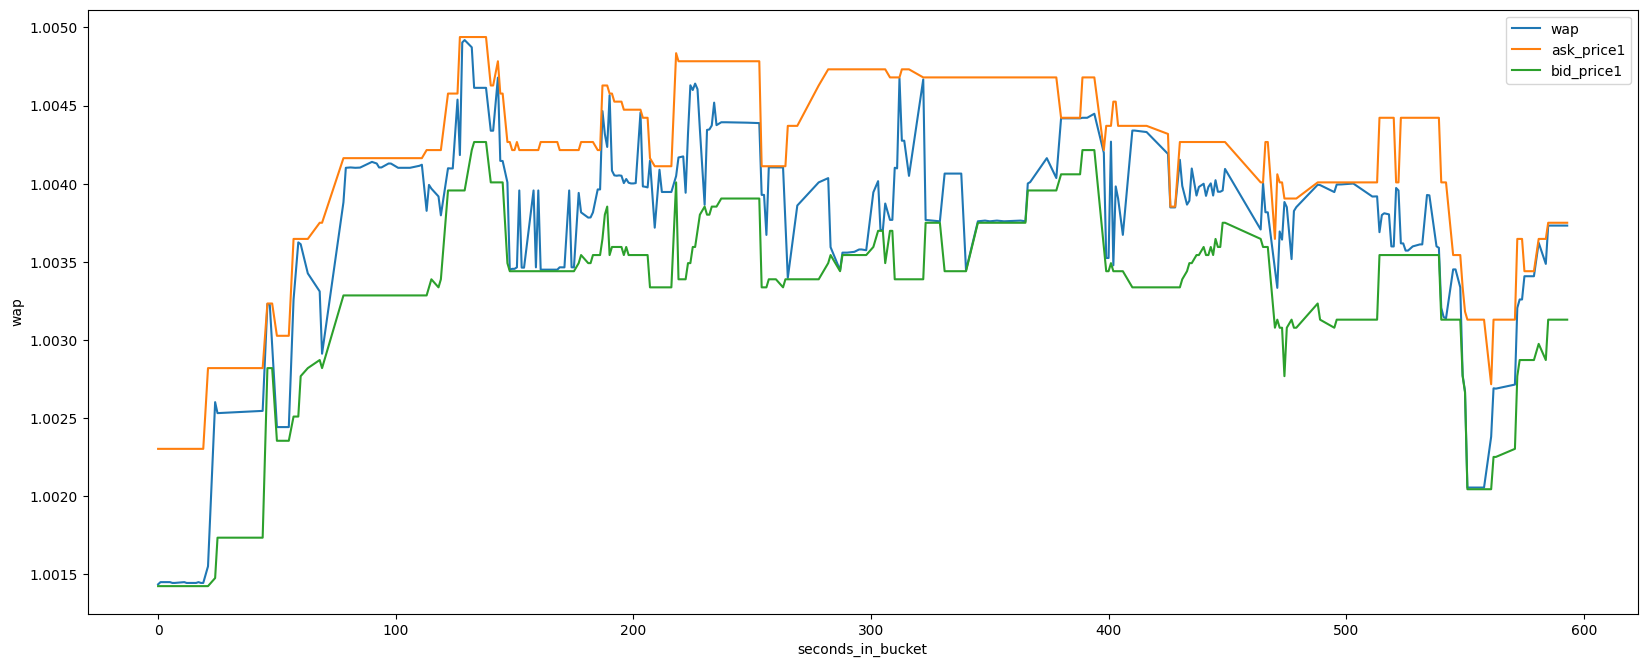

In [4]:
book_example['wap'] = (book_example['bid_price1'] * book_example['ask_size1'] +
                                book_example['ask_price1'] * book_example['bid_size1']) / (
                                       book_example['bid_size1']+ book_example['ask_size1'])
print('加权平均价格的计算：')
plt.figure(figsize=(20, 8), dpi=100)
fig = sns.lineplot(x=book_example['seconds_in_bucket'],y=book_example['wap'])
sns.lineplot(x=book_example['seconds_in_bucket'],y=book_example['ask_price1'])
sns.lineplot(x=book_example['seconds_in_bucket'],y=book_example['bid_price1'])
fig.legend(['wap','ask_price1','bid_price1'])
plt.show()

<a id='step3'></a>
# 3. 探索性数据分析

In [5]:
### 读取数据
# Function to read our base train and test set
def read_train_test():
    train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
    test = pd.read_csv('../input/optiver-realized-volatility-prediction/test.csv')
    # Create a key to merge with book and trade data
    # 将stock_id和time_id编码为唯一的row_id
    train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
    test['row_id'] = test['stock_id'].astype(str) + '-' + test['time_id'].astype(str)
    print('训练集有 {} 只股票'.format(len(train['stock_id'].unique())))
    print('训练集有 {} 个时间戳'.format(len(train['time_id'].unique())))
    print(f'训练集有 {train.shape[0]} 行')
    print(train.head())
    return train, test

# Read train and test
train, test = read_train_test()

训练集有 112 只股票
训练集有 3830 个时间戳
训练集有 428932 行
   stock_id  time_id    target row_id
0         0        5  0.004136    0-5
1         0       11  0.001445   0-11
2         0       16  0.002168   0-16
3         0       31  0.002195   0-31
4         0       62  0.001747   0-62


### 实际波动率的分布情况

target
------
Mean: 0.0039  -  Median: 0.0030  -  Std: 0.0029
Min: 0.0001  -  25%: 0.0020  -  50%: 0.0030  -  75%: 0.0047  -  Max: 0.0703
Skew: 2.8226  -  Kurtosis: 14.9611
Missing Values: 0/428932 (0.0000%)


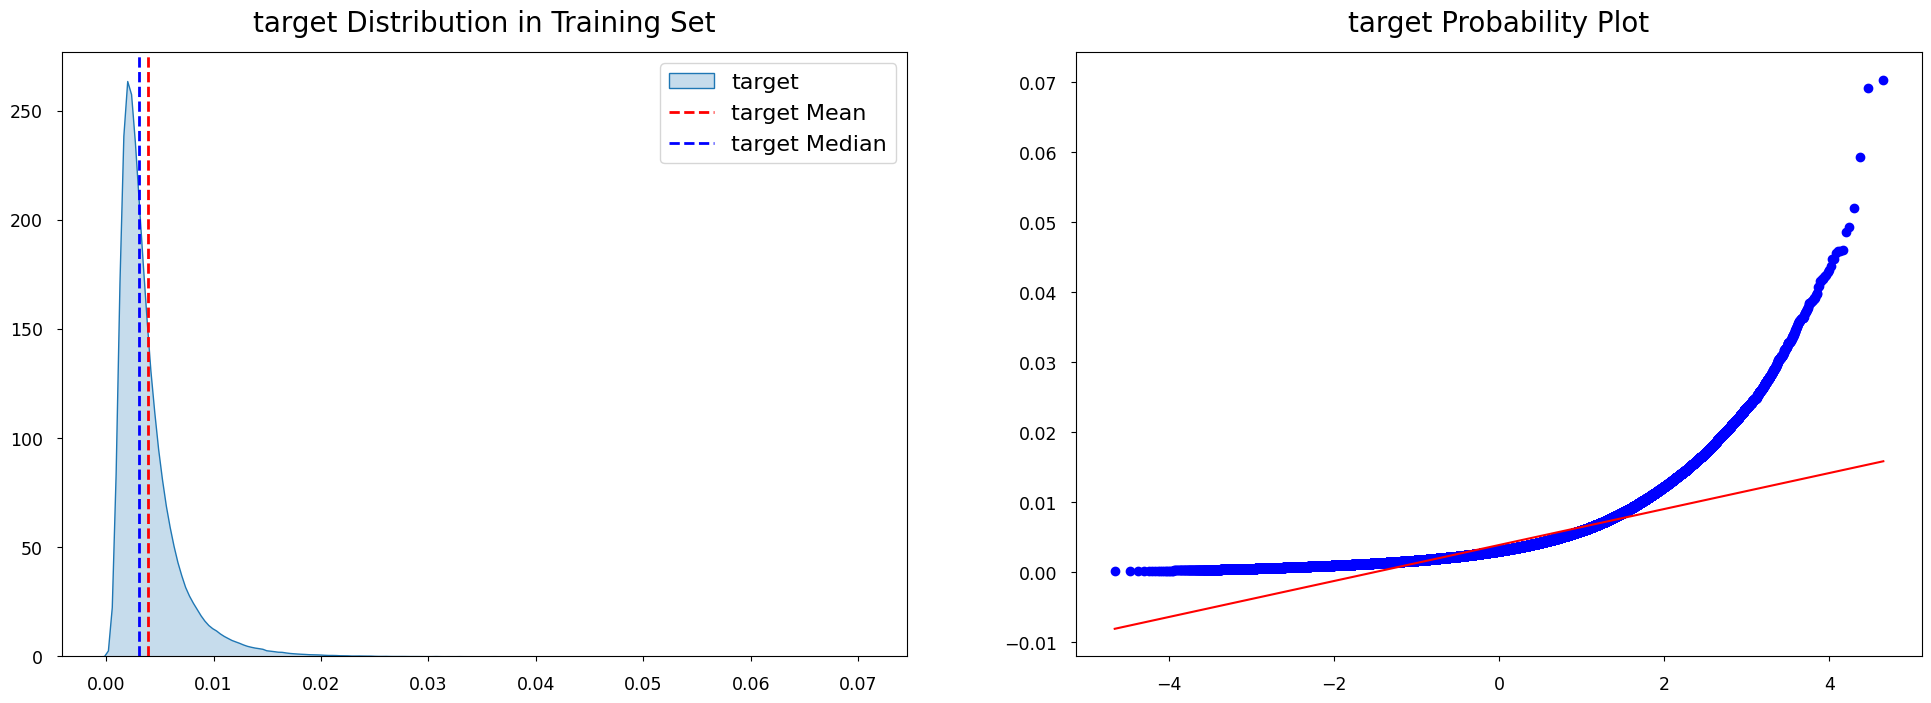

In [6]:
def visualize_target(target):
    
    print(f'{target}\n{"-" * len(target)}')
        
    print(f'Mean: {train[target].mean():.4f}  -  Median: {train[target].median():.4f}  -  Std: {train[target].std():.4f}')
    print(f'Min: {train[target].min():.4f}  -  25%: {train[target].quantile(0.25):.4f}  -  50%: {train[target].quantile(0.5):.4f}  -  75%: {train[target].quantile(0.75):.4f}  -  Max: {train[target].max():.4f}')
    print(f'Skew: {train[target].skew():.4f}  -  Kurtosis: {train[target].kurtosis():.4f}')
    missing_values_count = train[train[target].isnull()].shape[0]
    training_samples_count = train.shape[0]
    print(f'Missing Values: {missing_values_count}/{training_samples_count} ({missing_values_count * 100 / training_samples_count:.4f}%)')

    fig, axes = plt.subplots(ncols=2, figsize=(24, 8), dpi=100)
    sns.kdeplot(train[target], label=target, shade =True, ax=axes[0])
    axes[0].axvline(train[target].mean(), label=f'{target} Mean', color='r', linewidth=2, linestyle='--')
    axes[0].axvline(train[target].median(), label=f'{target} Median', color='b', linewidth=2, linestyle='--')
    probplot(train[target], plot=axes[1])
    axes[0].legend(prop={'size': 16})
    
    for i in range(2):
        axes[i].tick_params(axis='x', labelsize=12.5, pad=10)
        axes[i].tick_params(axis='y', labelsize=12.5, pad=10)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
    axes[0].set_title(f'{target} Distribution in Training Set', fontsize=20, pad=15)
    axes[1].set_title(f'{target} Probability Plot', fontsize=20, pad=15)

    plt.show()
    
visualize_target('target')

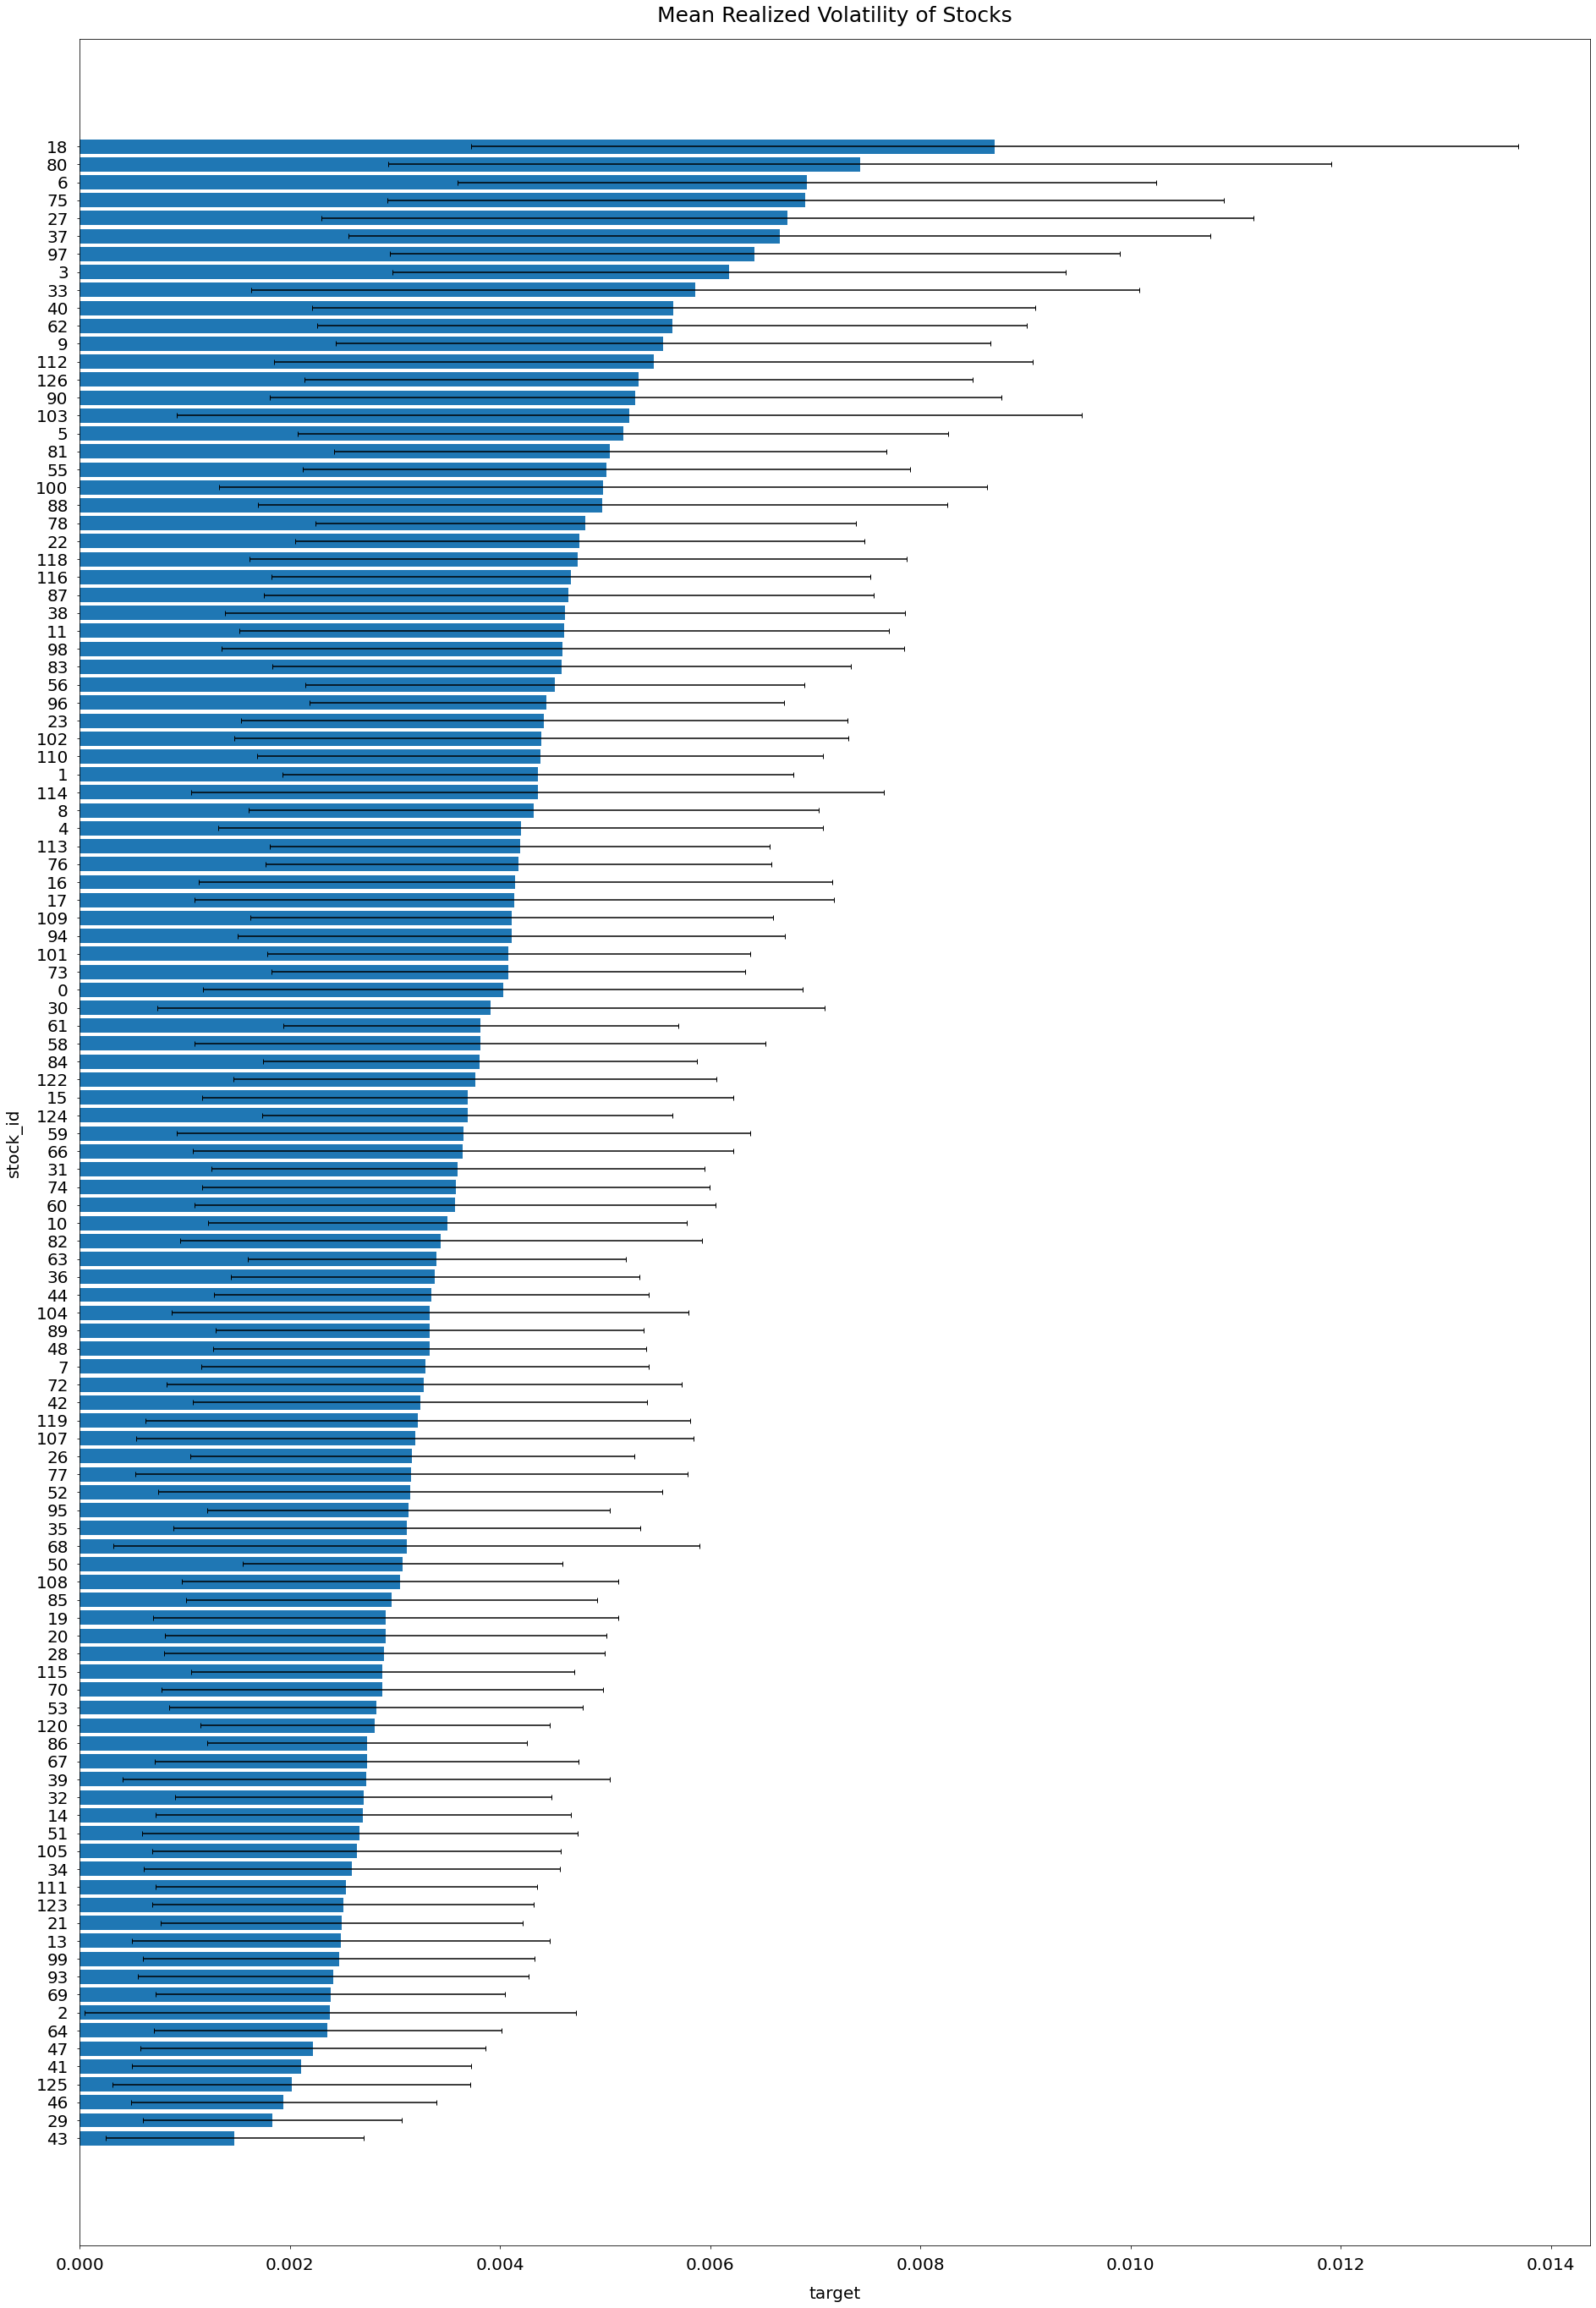

In [7]:
target_means = train.groupby('stock_id')['target'].mean()
target_stds = train.groupby('stock_id')['target'].std()

target_means_and_stds = pd.concat([target_means, target_stds], axis=1)
target_means_and_stds.columns = ['mean', 'std']
target_means_and_stds.sort_values(by='mean', ascending=True, inplace=True)

fig, ax = plt.subplots(figsize=(32, 48))
ax.barh(
    y=np.arange(len(target_means_and_stds)),
    width=target_means_and_stds['mean'],
    xerr=target_means_and_stds['std'],
    align='center',
    ecolor='black',
    capsize=3
)

ax.set_yticks(np.arange(len(target_means_and_stds)))
ax.set_yticklabels(target_means_and_stds.index)
ax.set_xlabel('target', size=20, labelpad=15)
ax.set_ylabel('stock_id', size=20, labelpad=15)
ax.tick_params(axis='x', labelsize=20, pad=10)
ax.tick_params(axis='y', labelsize=20, pad=10)
ax.set_title('Mean Realized Volatility of Stocks', size=25, pad=20)

plt.show()

del target_means, target_stds, target_means_and_stds

我们可以看到，目标变量是高度右偏的，存在一些非常不稳定的股票，它们有异常高的波动率。

In [8]:
def read_book_data(dataset, stock_id, sort=False, forward_fill=False):
        
    book_dtypes = {
        'time_id': np.uint16,
        'seconds_in_bucket': np.uint16,
        'bid_price1': np.float32,
        'ask_price1': np.float32,
        'bid_price2': np.float32,
        'ask_price2': np.float32,
        'bid_size1': np.uint32,
        'ask_size1': np.uint32,
        'bid_size2': np.uint32,
        'ask_size2': np.uint32,
    }

    df_book = pd.read_parquet(f'../input/optiver-realized-volatility-prediction/book_{dataset}.parquet/stock_id={stock_id}')
    for column, dtype in book_dtypes.items():
        df_book[column] = df_book[column].astype(dtype)
    
    if sort:
        df_book.sort_values(by=['time_id', 'seconds_in_bucket'], inplace=True)
        
    if forward_fill:
        df_book = df_book.set_index(['time_id', 'seconds_in_bucket'])
        df_book = df_book.reindex(pd.MultiIndex.from_product([df_book.index.levels[0], np.arange(0, 600)], names=['time_id', 'seconds_in_bucket']), method='ffill')
        df_book.reset_index(inplace=True)

    return df_book

for stock_id in tqdm(sorted(train['stock_id'].unique())):
            
    df_book = read_book_data('train', stock_id)

    # Weighted averaged prices
    df_book['wap1'] = (df_book['bid_price1'] * df_book['ask_size1'] + df_book['ask_price1'] * df_book['bid_size1']) /\
                      (df_book['bid_size1'] + df_book['ask_size1'])
    df_book['wap2'] = (df_book['bid_price2'] * df_book['ask_size2'] + df_book['ask_price2'] * df_book['bid_size2']) /\
                      (df_book['bid_size2'] + df_book['ask_size2'])

    # Realized volatilities
    for wap in [1, 2]:
        df_book[f'log_return_from_wap{wap}'] = np.log(df_book[f'wap{wap}'] / df_book.groupby('time_id')[f'wap{wap}'].shift(1))
        df_book[f'squared_log_return_from_wap{wap}'] = df_book[f'log_return_from_wap{wap}'] ** 2
        df_book[f'realized_volatility_from_wap{wap}'] = np.sqrt(df_book.groupby('time_id')[f'squared_log_return_from_wap{wap}'].transform('sum'))
        df_book.drop(columns=[f'squared_log_return_from_wap{wap}'], inplace=True)            
        realized_volatilities = df_book.groupby('time_id')[f'realized_volatility_from_wap{wap}'].first().to_dict()
        train.loc[train['stock_id'] == stock_id, f'realized_volatility_from_wap{wap}'] = train[train['stock_id'] == stock_id]['time_id'].map(realized_volatilities)
        
def visualize_book_time_bucket(stock_id, time_id):
    
    time_bucket = (train['stock_id'] == stock_id) & (train['time_id'] == time_id)
    
    target = train.loc[time_bucket, 'target'].iloc[0]
    realized_volatility = train.loc[time_bucket, 'realized_volatility_from_wap1'].iloc[0]
    df_book = read_book_data('train', stock_id, sort=True, forward_fill=True)
    df_book = df_book.set_index('seconds_in_bucket')
    
    df_book['wap1'] = (df_book['bid_price1'] * df_book['ask_size1'] + df_book['ask_price1'] * df_book['bid_size1']) /\
                      (df_book['bid_size1'] + df_book['ask_size1'])
    df_book['wap2'] = (df_book['bid_price2'] * df_book['ask_size2'] + df_book['ask_price2'] * df_book['bid_size2']) /\
                      (df_book['bid_size2'] + df_book['ask_size2'])
    
    fig, axes = plt.subplots(figsize=(32, 30), nrows=2)
    
    axes[0].plot(df_book.loc[df_book['time_id'] == time_id, 'bid_price1'], label='bid_price1', lw=2, color='tab:green')
    axes[0].plot(df_book.loc[df_book['time_id'] == time_id, 'ask_price1'], label='ask_price1', lw=2, color='tab:red')
    axes[0].plot(df_book.loc[df_book['time_id'] == time_id, 'bid_price2'], label='bid_price2', alpha=0.3, color='tab:green')
    axes[0].plot(df_book.loc[df_book['time_id'] == time_id, 'ask_price2'], label='ask_price2', alpha=0.3, color='tab:red')
    axes[0].plot(df_book.loc[df_book['time_id'] == time_id, 'wap1'], label='wap1', lw=2, linestyle='--', color='tab:blue')
    axes[0].plot(df_book.loc[df_book['time_id'] == time_id, 'wap2'], label='wap2', alpha=0.3, linestyle='--',  color='tab:blue')
    
    axes[1].plot(df_book.loc[df_book['time_id'] == time_id, 'bid_size1'], label='bid_size1', lw=2, color='tab:green')
    axes[1].plot(df_book.loc[df_book['time_id'] == time_id, 'ask_size1'], label='ask_size1', lw=2, color='tab:red')
    axes[1].plot(df_book.loc[df_book['time_id'] == time_id, 'bid_size2'], label='bid_size2', alpha=0.3, color='tab:green')
    axes[1].plot(df_book.loc[df_book['time_id'] == time_id, 'ask_size2'], label='ask_size2', alpha=0.3, color='tab:red')
    
    for i in range(2):
        axes[i].legend(prop={'size': 18})
        axes[i].tick_params(axis='x', labelsize=20, pad=10)
        axes[i].tick_params(axis='y', labelsize=20, pad=10)
    axes[0].set_ylabel('price', size=20, labelpad=15)
    axes[1].set_ylabel('size', size=20, labelpad=15)
    
    axes[0].set_title(
        f'Prices of stock_id {stock_id} time_id {time_id} - Current Realized Volatility: {realized_volatility:.6f} - Next 10 minute Realized Volatility: {target:.6f}',
        size=25,
        pad=15
    )
    axes[1].set_title(
        f'Sizes of stock_id {stock_id} time_id {time_id} - Current Realized Volatility: {realized_volatility:.6f} - Next 10 minute Realized Volatility: {target:.6f}',
        size=25,
        pad=15
    )
    
    plt.show()

  0%|          | 0/112 [00:00<?, ?it/s]

### 使用 visualize_book_time_bucket 函数可视化订单价格和订单大小
股票 77 的 24600 时间段是训练集中实际波动率最大的时间段

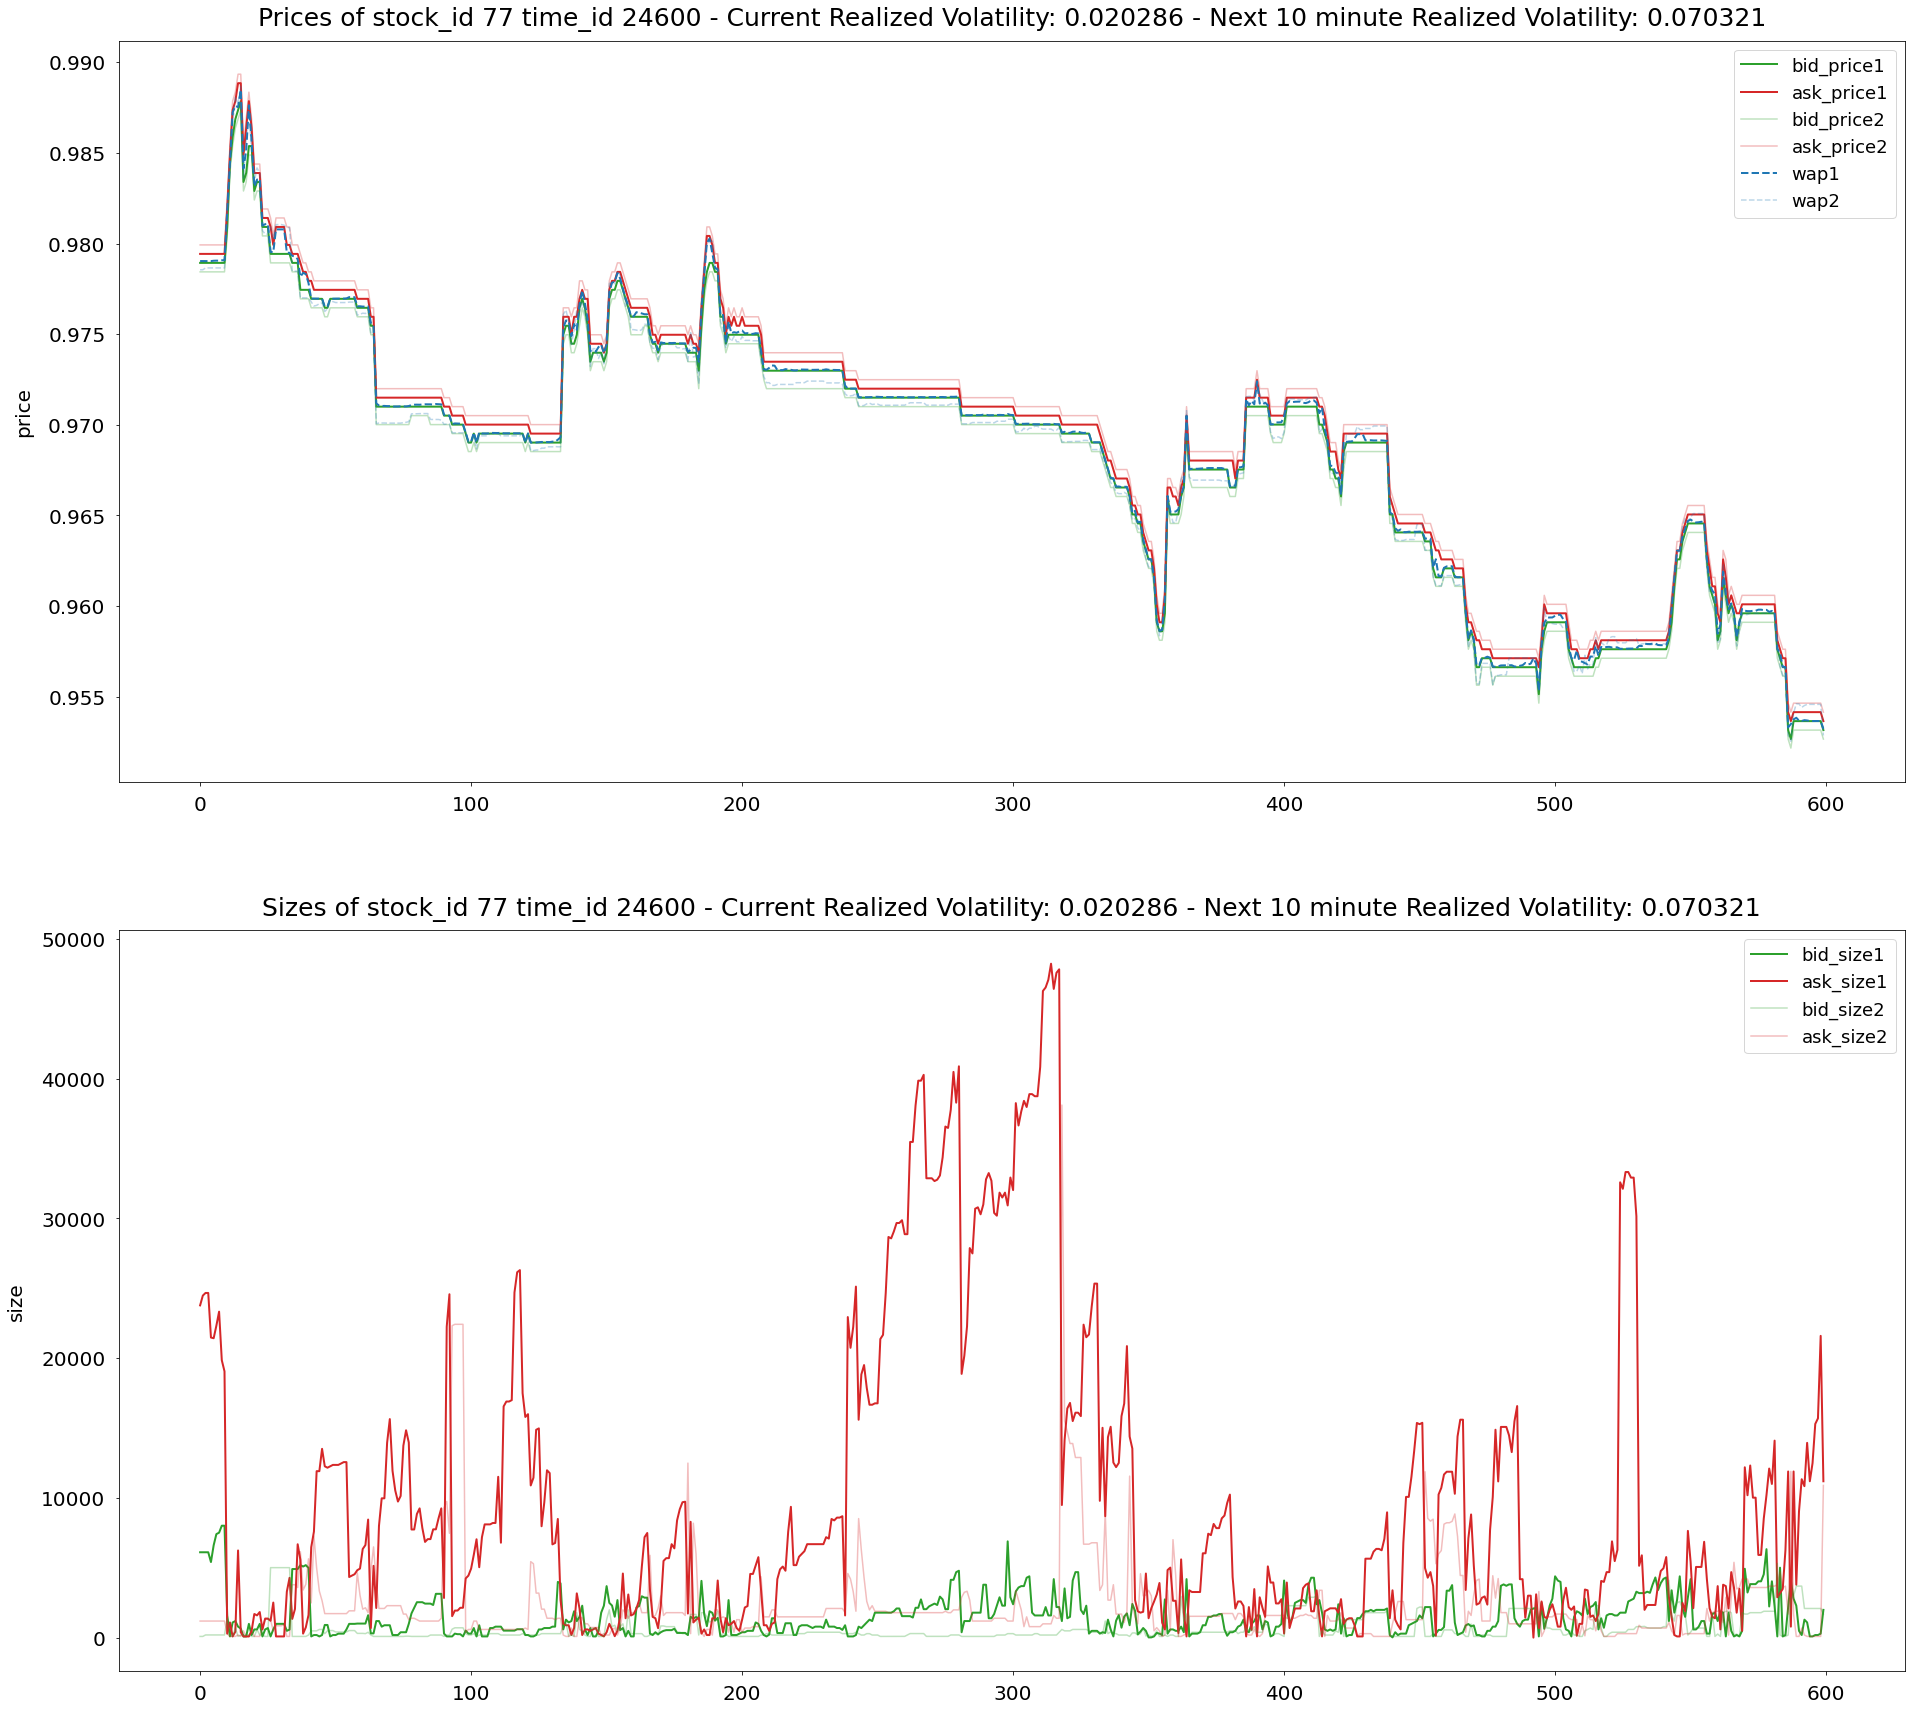

In [9]:
visualize_book_time_bucket(stock_id=77, time_id=24600)

<a id='step4'></a>
# 4. 特征工程

在此竞赛中，我们使用量化特征工程方法进行数据维度的扩充，主要包括：

* Weighted averaged price，WAP：加权平均价格
* Log return：对数收益率
* Realized volatility：历史的波动率
* Count unique：表示每个time id中有多少秒有记录，这个特征与标的的流动性相关
* Max,Min,Std：抽取最大值、最小值、均值、标准差等特征

In [10]:
# data directory
data_dir = '../input/optiver-realized-volatility-prediction/'
train, test = read_train_test()

# Function to calculate first WAP
def calc_wap1(df):
    '''
    Weighted averaged price1
    bid的量多时，实际价格偏向ask要价
    ''' 
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

# Function to calculate second WAP
def calc_wap2(df):
    '''
    Weighted averaged price
    '''
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

def calc_wap3(df):
    '''
    Weighted averaged price
    符合一般直觉的加权价格，同一方的size和price相乘
    ''' 
    wap = (df['bid_price1'] * df['bid_size1'] + df['ask_price1'] * df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

def calc_wap4(df):
    '''
    Weighted averaged price
    '''
    wap = (df['bid_price2'] * df['bid_size2'] + df['ask_price2'] * df['ask_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

# Function to calculate the log of the return
# Remember that logb(x / y) = logb(x) - logb(y)
def log_return(series):
    '''
    对series取log之后求差分（得到return的log）
    '''
    return np.log(series).diff()

# Calculate the realized volatility
def realized_volatility(series):
    '''
    对log_return的平方求和后开方得到realized_volatility（series为一定区间内的log_return）
    '''
    return np.sqrt(np.sum(series**2))

# Function to count unique elements of a series
def count_unique(series):
    '''
    用来计算seconds_in_bucket的数量
    '''
    return len(np.unique(series))

训练集有 112 只股票
训练集有 3830 个时间戳
训练集有 428932 行
   stock_id  time_id    target row_id
0         0        5  0.004136    0-5
1         0       11  0.001445   0-11
2         0       16  0.002168   0-16
3         0       31  0.002195   0-31
4         0       62  0.001747   0-62


## 抽取订单簿数据特征

In [11]:
# Function to preprocess book data (for each stock id)
def book_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    # Calculate Wap
    # 计算每行的加权平均价格
    df['wap1'] = calc_wap1(df)
    df['wap2'] = calc_wap2(df)
    df['wap3'] = calc_wap3(df)
    df['wap4'] = calc_wap4(df)
    # Calculate log returns
    # 根据加权平均价格计算log_return
    df['log_return1'] = df.groupby(['time_id'])['wap1'].apply(log_return)
    df['log_return2'] = df.groupby(['time_id'])['wap2'].apply(log_return)
    df['log_return3'] = df.groupby(['time_id'])['wap3'].apply(log_return)
    df['log_return4'] = df.groupby(['time_id'])['wap4'].apply(log_return)
    # Calculate wap balance
    # 计算bid和ask的差（差值越大，volatility越大）
    df['wap_balance'] = abs(df['wap1'] - df['wap2'])
    # Calculate spread
    # 价格差价比率
    # 价格差价的差
    # volume ask量和bid量的大差值意味着低流动性，会导致高波动率
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)
    df['price_spread2'] = (df['ask_price2'] - df['bid_price2']) / ((df['ask_price2'] + df['bid_price2']) / 2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df["bid_ask_spread"] = abs(df['bid_spread'] - df['ask_spread'])
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))
    
    # Dict for aggregations
    # 统计特征
    create_feature_dict = {
        'wap1': [np.sum, np.std],
        'wap2': [np.sum, np.std],
        'wap3': [np.sum, np.std],
        'wap4': [np.sum, np.std],
        'log_return1': [realized_volatility],
        'log_return2': [realized_volatility],
        'log_return3': [realized_volatility],
        'log_return4': [realized_volatility],
        'wap_balance': [np.sum, np.max],
        'price_spread':[np.sum, np.max],
        'price_spread2':[np.sum, np.max],
        'bid_spread':[np.sum, np.max],
        'ask_spread':[np.sum, np.max],
        'total_volume':[np.sum, np.max],
        'volume_imbalance':[np.sum, np.max],
        "bid_ask_spread":[np.sum,  np.max],
    }
    # 波动率特征
    create_feature_dict_time = {
        'log_return1': [realized_volatility],
        'log_return2': [realized_volatility],
        'log_return3': [realized_volatility],
        'log_return4': [realized_volatility],
    }
    
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(fe_dict,seconds_in_bucket, add_suffix = False):
        '''
        获取滑动窗口中的特征
        '''
        # Group by the window
        # 根据时间窗口进行分组
        # 再对每个time_bucket获取统计特征
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(fe_dict).reset_index()
        # Rename columns joining suffix
        # 对groupby之后产生的多层目录重命名
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        # 给列名加后缀 _{seconds_in_bucket} e.g. fea_name_500 
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    
    # Get the stats for different windows
    # 获取整个区间的统计特征
    df_feature = get_stats_window(create_feature_dict,seconds_in_bucket = 0, add_suffix = False)
    # 获取不同时间窗口的波动率特征 （create_feature_dict_time）
    # 500代表在每个time_id区间里seconds_in_bucket>500的记录
    df_feature_500 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 500, add_suffix = True)
    df_feature_400 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 200, add_suffix = True)
    df_feature_100 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 100, add_suffix = True)

    # Merge all
    df_feature = df_feature.merge(df_feature_500, how = 'left', left_on = 'time_id_', right_on = 'time_id__500')
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')
    df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__500','time_id__400', 'time_id__300', 'time_id__200','time_id__100'], axis = 1, inplace = True)
    
    
    # Create row_id so we can merge
    stock_id = file_path.split('=')[1]
    # row_id 为 stock_id-time_id e.g.
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x: f'{stock_id}-{x}')
    df_feature.drop(['time_id_'], axis = 1, inplace = True)
    return df_feature


## 抽取交易数据特征

In [12]:
# Function to preprocess trade data (for each stock id)
# 逐个股票的交易数据特征提取
def trade_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    # 获取一个time_bucket中的log_return （对price求差分后取log）
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return)
    # 获取成交额
    df['amount']=df['price']*df['size']
    # Dict for aggregations
    # 聚合特征：波动率和统计特征
    create_feature_dict = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum, np.max, np.min],
        'order_count':[np.sum,np.max],
        'amount':[np.sum,np.max,np.min],
    }
    # 时间窗口聚合特征
    create_feature_dict_time = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum],
        'order_count':[np.sum],
    }
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(fe_dict,seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(fe_dict).reset_index()
        # Rename columns joining suffix
        # 对groupby之后产生的多层目录重命名
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    

    # Get the stats for different windows
    # 计算聚合的波动率和统计特征
    df_feature = get_stats_window(create_feature_dict,seconds_in_bucket = 0, add_suffix = False)
    # 计算各个时间窗口的特征
    df_feature_500 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 500, add_suffix = True)
    df_feature_400 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 200, add_suffix = True)
    df_feature_100 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 100, add_suffix = True)
    
    def tendency(price, vol):    
        # 差分求价格变化的绝对值
        df_diff = np.diff(price)
        # 计算价格变化的百分比
        val = (df_diff/price[1:])*100
        # time_bucket内每个时间单位的 变化百分比 x 成交量 求和得到趋势
        power = np.sum(val*vol[1:])
        return(power)
    
    lis = []
    for n_time_id in df['time_id'].unique():
        df_id = df[df['time_id'] == n_time_id]
        # 计算成交趋势
        tendencyV = tendency(df_id['price'].values, df_id['size'].values) 
        # 均价以上成交的时间数量（seconds_in_bucket计数）
        f_max = np.sum(df_id['price'].values > np.mean(df_id['price'].values))
        # 均价以上成交的时间数量（seconds_in_bucket计数）
        f_min = np.sum(df_id['price'].values < np.mean(df_id['price'].values))
        # 价格上涨的次数
        df_max =  np.sum(np.diff(df_id['price'].values) > 0)
        # 价格下跌的次数
        df_min =  np.sum(np.diff(df_id['price'].values) < 0)
        # new
        # 价格减均价的绝对值的中位数，衡量价格偏移
        abs_diff = np.median(np.abs( df_id['price'].values - np.mean(df_id['price'].values)))        
        # 价格的平方均值（能量函数）得 time_bucket 的能量
        energy = np.mean(df_id['price'].values**2)
        # 计算 time_bucket 中价格的四分位数差（75分位数-25分位数）
        iqr_p = np.percentile(df_id['price'].values,75) - np.percentile(df_id['price'].values,25)
        
        # vol vars
        # 成交量减成交量均值的绝对值的中位数，衡量成交量偏移
        abs_diff_v = np.median(np.abs( df_id['size'].values - np.mean(df_id['size'].values)))
        # 成交量的能量
        energy_v = np.sum(df_id['size'].values**2)
        # 成交量的四分位数差
        iqr_p_v = np.percentile(df_id['size'].values,75) - np.percentile(df_id['size'].values,25)
        #字典存放到list里
        lis.append({'time_id':n_time_id,'tendency':tendencyV,'f_max':f_max,'f_min':f_min,'df_max':df_max,'df_min':df_min,
                   'abs_diff':abs_diff,'energy':energy,'iqr_p':iqr_p,'abs_diff_v':abs_diff_v,'energy_v':energy_v,'iqr_p_v':iqr_p_v})
    
    df_lr = pd.DataFrame(lis)
        
   
    df_feature = df_feature.merge(df_lr, how = 'left', left_on = 'time_id_', right_on = 'time_id')
    
    # Merge all
    # 凭借各个时间窗口的特征
    df_feature = df_feature.merge(df_feature_500, how = 'left', left_on = 'time_id_', right_on = 'time_id__500')
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')
    df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__500','time_id__400', 'time_id__300', 'time_id__200','time_id','time_id__100'], axis = 1, inplace = True)
    
    
    df_feature = df_feature.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature.drop(['trade_time_id_'], axis = 1, inplace = True)
    return df_feature


## 抽取每个时间段、每只股票的统计特征

In [13]:
# Function to get group stats for the stock_id and time_id
def get_time_stock(df):
    '''
    获取stock-wise和time_bucket-wise的统计特征
    '''
    vol_cols = ['log_return1_realized_volatility', 'log_return2_realized_volatility', 'log_return1_realized_volatility_400', 'log_return2_realized_volatility_400', 
                'log_return1_realized_volatility_300', 'log_return2_realized_volatility_300', 'log_return1_realized_volatility_200', 'log_return2_realized_volatility_200', 
                'trade_log_return_realized_volatility', 'trade_log_return_realized_volatility_400', 'trade_log_return_realized_volatility_300', 'trade_log_return_realized_volatility_200']


    # Group by the stock id
    # 获取stock-wise的统计特征
    df_stock_id = df.groupby(['stock_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_stock_id.columns = ['_'.join(col) for col in df_stock_id.columns]
    df_stock_id = df_stock_id.add_suffix('_' + 'stock')

    # Group by the stock id
    # 获取time_bucket-wise的统计特征
    df_time_id = df.groupby(['time_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_time_id.columns = ['_'.join(col) for col in df_time_id.columns]
    df_time_id = df_time_id.add_suffix('_' + 'time')
    
    # Merge with original dataframe
    # 和训练集或测试集merge
    df = df.merge(df_stock_id, how = 'left', left_on = ['stock_id'], right_on = ['stock_id__stock'])
    df = df.merge(df_time_id, how = 'left', left_on = ['time_id'], right_on = ['time_id__time'])
    df.drop(['stock_id__stock', 'time_id__time'], axis = 1, inplace = True)
    return df


## 并行化，缩短运行时间

In [14]:
# Funtion to make preprocessing function in parallel (for each stock id)
def preprocessor(list_stock_ids, is_train = True):
    
    # Parrallel for loop
    # 对每个stock并行处理函数
    def for_joblib(stock_id):
        # Train
        if is_train:
            file_path_book = data_dir + "book_train.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)
        # Test
        else:
            file_path_book = data_dir + "book_test.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_test.parquet/stock_id=" + str(stock_id)
    
        # Preprocess book and trade data and merge them
        df_tmp = pd.merge(book_preprocessor(file_path_book), trade_preprocessor(file_path_trade), on = 'row_id', how = 'left')
        
        # Return the merge dataframe
        return df_tmp
    
    # Use parallel api to call paralle for loop
    # 使用 delayed 和 Parallel 并行计算特征（通常与pd.DataFrame的apply函数配合使用）
    df = Parallel(n_jobs = -1, verbose = 1)(delayed(for_joblib)(stock_id) for stock_id in list_stock_ids)
    # Concatenate all the dataframes that return from Parallel
    df = pd.concat(df, ignore_index = True)
    return df

In [15]:
# Get unique stock ids 
train_stock_ids = train['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
train_ = preprocessor(train_stock_ids, is_train = True)
train = train.merge(train_, on = ['row_id'], how = 'left')

# Get unique stock ids 
test_stock_ids = test['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
test_ = preprocessor(test_stock_ids, is_train = False)
test = test.merge(test_, on = ['row_id'], how = 'left')

# Get group stats of time_id and stock_id
train = get_time_stock(train)
test = get_time_stock(test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed: 34.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


### 还可以增加一些 tau 特征

In [16]:
# 对seconds_in_bucket_count和order_count构造tau特征
# 因为这是对特征的单调变换，对GBDT模型（LightGBM,XGBoost）影响很小，对神经网络可能有影响
train['size_tau'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique'] )
test['size_tau'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique'] )
train['size_tau_400'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_400'] )
test['size_tau_400'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_400'] )
train['size_tau_300'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_300'] )
test['size_tau_300'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_300'] )
train['size_tau_200'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_200'] )
test['size_tau_200'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_200'] )

train['size_tau2'] = np.sqrt( 1/ train['trade_order_count_sum'] )
test['size_tau2'] = np.sqrt( 1/ test['trade_order_count_sum'] )
train['size_tau2_400'] = np.sqrt( 0.33/ train['trade_order_count_sum'] )
test['size_tau2_400'] = np.sqrt( 0.33/ test['trade_order_count_sum'] )
train['size_tau2_300'] = np.sqrt( 0.5/ train['trade_order_count_sum'] )
test['size_tau2_300'] = np.sqrt( 0.5/ test['trade_order_count_sum'] )
train['size_tau2_200'] = np.sqrt( 0.66/ train['trade_order_count_sum'] )
test['size_tau2_200'] = np.sqrt( 0.66/ test['trade_order_count_sum'] )

# 对tau特征再做差
train['size_tau2_d'] = train['size_tau2_400'] - train['size_tau2']
test['size_tau2_d'] = test['size_tau2_400'] - test['size_tau2']

# 我们现在有194个特征了
colNames = [col for col in list(train.columns)
            if col not in {"stock_id", "time_id", "target", "row_id"}]
len(colNames)

194

<a id='question1'></a>
## 问题 1：

根据股票的板块效应（**相同板块的股票，走势应该相似，而不同板块的股票，走势差异较大**），构造相关的特征（**提示：使用相关系数，聚类算法，再计算每个cluster的统计特征**）

In [17]:
train_p = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
train_p = train_p.pivot(index='time_id', columns='stock_id', values='target')

################在下方构造特征####################
##############计算皮尔森相关系数##################


##################K-Means聚类#####################


#####从训练集、测试集中抽取每个cluster的数据######


#############计算每个cluster的特征################


###########新特征与训练集，测试集拼接#############


################这是一大段代码####################

In [18]:
# stock_id作为列名，time_id作为index，value为log_return1_realized_volatility的dataframe
train_p2 = train.pivot(index='time_id', columns='stock_id', values='log_return1_realized_volatility')
# 每列的均值填充缺失值
train_p2 = train_p2.fillna(train_p2.mean())

# 对测试集相同操作
test_p2 = test.pivot(index='time_id', columns='stock_id', values='log_return1_realized_volatility')
# 测试集的time_id少于20个的情况下
if len(test_p2)<=20:
    test_p2[0] =  [0.001,0.222,0.333]
    # 用训练集来测试代码
    # 测试集的time_id和训练集不一致
    test_p2 = pd.concat([train_p2.head(20),test_p2])
# 用训练集均值填充测试集
test_p2 = test_p2.fillna(test_p2.mean())
,
from sklearn.neighbors import NearestNeighbors
# 用 (time_id，log_return1_realized_volatility) 做特征，用KNN
neigh = NearestNeighbors(n_neighbors=10)
nbrs = neigh.fit(train_p2)
# 用KNN获得每个time_id最近（用112个stock的log_return1_realized_volatility计算距离）9个time_id的Index
neighb = nbrs.kneighbors(train_p2,  return_distance=False)
neighb_dict = {}
# 将每个time_id最近的9个time_id放到字典中
# {time_id:[nb1,nb2,nb3...,nb9],}
for i,x in enumerate(train_p2.index):
    sss = train_p2.index
    neighb_dict[sss[neighb[i][0]]] = [sss[neighb[i][1]],sss[neighb[i][2]], sss[neighb[i][3]], sss[neighb[i][4]]]
    
# 筛选特征,下列步骤为扩充特征，将距离最近的两个time_id的部分特征的均值加入到特征中
timecols = ['log_return1_realized_volatility','total_volume_sum',\
           'trade_size_sum','trade_order_count_sum','price_spread_sum',\
           'bid_spread_sum','ask_spread_sum']

train2 = []
# 遍历train中的所有time_id
for xx in tqdm(train.groupby('time_id')):
    # xx[0]为当前遍历的time_id,获取train中离xx[0]最近的2个time_id的数据的df
    tmp = train[train.time_id.isin(neighb_dict[xx[0]][:2])]
    # tmp2为xx[0]的数据的df
    tmp2 = xx[1]
    # tmp3为xx[0]最近的两个time_id的timecols特征的均值
    tmp3 = tmp.groupby('stock_id')[timecols].mean()
    # 重命名列名
    tmp3.columns = [str(xx)+'_c2' for xx in tmp3.columns]
    tmp3 = tmp3.reset_index()
    # 与xx[0]的df拼接，扩充特征
    tmp2 = pd.merge(tmp2,tmp3,how='left',on='stock_id')
    train2.append(tmp2)
# 将所有数据拼接
train2 = pd.concat(train2).reset_index(drop=True)

# 对于测试集，重新计算time_id之间的距离
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=10)
nbrs = neigh.fit(test_p2)
neighb = nbrs.kneighbors(test_p2,  return_distance=False)
neighb_dict_test = {}
for i,x in enumerate(test_p2.index):
    sss = test_p2.index
    neighb_dict_test[sss[neighb[i][0]]] = [sss[neighb[i][1]],sss[neighb[i][2]], sss[neighb[i][3]], sss[neighb[i][4]]]
    
test2 = []
for xx in tqdm(test.groupby('time_id')):
    tmp = test[test.time_id.isin(neighb_dict_test[xx[0]][:2])]
    tmp2 = xx[1]
    tmp3 = tmp.groupby('stock_id')[timecols].mean()
    tmp3.columns = [str(xx)+'_c2' for xx in tmp3.columns]
    tmp3 = tmp3.reset_index()
    tmp2 = pd.merge(tmp2,tmp3,how='left',on='stock_id')
    test2.append(tmp2)
test2 = pd.concat(test2).reset_index(drop=True)

train = train2.copy()
test = test2.copy()

  0%|          | 0/3830 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

<a id='step5'></a>
# 5. 模型搭建与训练

Training fold 1


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[250]	training's l2: 1.98172e-07	training's RMSPE: 0.206208	valid_1's l2: 2.41169e-07	valid_1's RMSPE: 0.226488
[500]	training's l2: 1.80249e-07	training's RMSPE: 0.196662	valid_1's l2: 2.37438e-07	valid_1's RMSPE: 0.22473
Early stopping, best iteration is:
[520]	training's l2: 1.79369e-07	training's RMSPE: 0.196181	valid_1's l2: 2.37188e-07	valid_1's RMSPE: 0.224611
Training fold 2
Training until validation scores don't improve for 50 rounds
[250]	training's l2: 1.98201e-07	training's RMSPE: 0.205627	valid_1's l2: 2.57062e-07	valid_1's RMSPE: 0.236536
[500]	training's l2: 1.79944e-07	training's RMSPE: 0.195928	valid_1's l2: 2.54369e-07	valid_1's RMSPE: 0.235294
Early stopping, best iteration is:
[458]	training's l2: 1.82175e-07	training's RMSPE: 0.197139	valid_1's l2: 2.54143e-07	valid_1's RMSPE: 0.23519
Training fold 3
Training until validation scores don't improve for 50 rounds
[250]	training's l2: 2.02413e-07	training's R

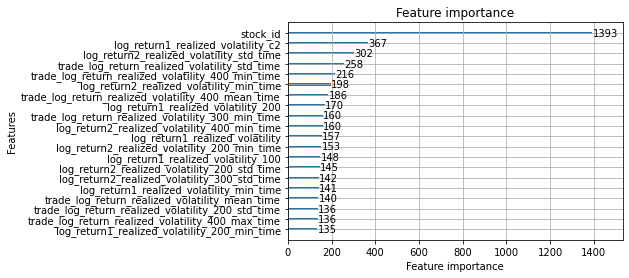

In [19]:
# 选用LightGBM模型
seed0=2021
params = {
    'objective': 'rmse',
    'boosting_type': 'gbdt',
    'max_depth': -1,
    'max_bin':100,
    'min_data_in_leaf':500,
    'learning_rate': 0.03,
    'subsample': 0.72,
    'subsample_freq': 4,
    'feature_fraction': 0.5,
    'lambda_l1': 0.5,
    'lambda_l2': 1.0,
    'categorical_column':[0],
    'seed':seed0,
    'feature_fraction_seed': seed0,
    'bagging_seed': seed0,
    'drop_seed': seed0,
    'data_random_seed': seed0,
    'n_jobs':-1,
    'verbose': -1}

# Function to early stop with root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

def train_and_evaluate_lgb(train, test, params):
    # Hyperparammeters (just basic)
    
    features = [col for col in train.columns if col not in {"time_id", "target", "row_id"}]
    y = train['target']
    # Create out of folds array
    oof_predictions = np.zeros(train.shape[0])
    # Create test array to store predictions
    test_predictions = np.zeros(test.shape[0])
    # Create a KFold object
    kfoldgroup = GroupKFold(n_splits = 5)
    for fold, (trn_ind, val_ind) in enumerate(kfoldgroup.split(range(len(train)),train.target,train.time_id)):

        print(f'Training fold {fold + 1}')
        x_train, x_val = train.iloc[trn_ind], train.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train[features], y_train, weight = train_weights)
        val_dataset = lgb.Dataset(x_val[features], y_val, weight = val_weights)
        model = lgb.train(params = params,
                          num_boost_round=1000,
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          verbose_eval = 250,
                          early_stopping_rounds=50,
                          feval = feval_rmspe)
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val[features])
        # Predict the test set
        test_predictions += model.predict(test[features]) / 5
    rmspe_score = rmspe(y, oof_predictions)
    print(f'Our out of folds RMSPE is {rmspe_score}')
    lgb.plot_importance(model,max_num_features=20)
    # Return test predictions
    return test_predictions

# Traing and evaluate
predictions_lgb= train_and_evaluate_lgb(train, test, params)
test['target'] = predictions_lgb
test[['row_id', 'target']].to_csv('submission.csv',index = False)

原始代码 Private Score 为0.22147，位列329/3852。